In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import scanpy as sc
import pandas as pd
import seaborn as sns
import meld 

/var/folders/w_/4hd3_h1n1lbdkxl3d_ttxh8c0000gn/T/ipykernel_45387/1143906630.py:26: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  cluster_samples = np.random.multivariate_normal(mean, cov, n_samples_per_cluster)


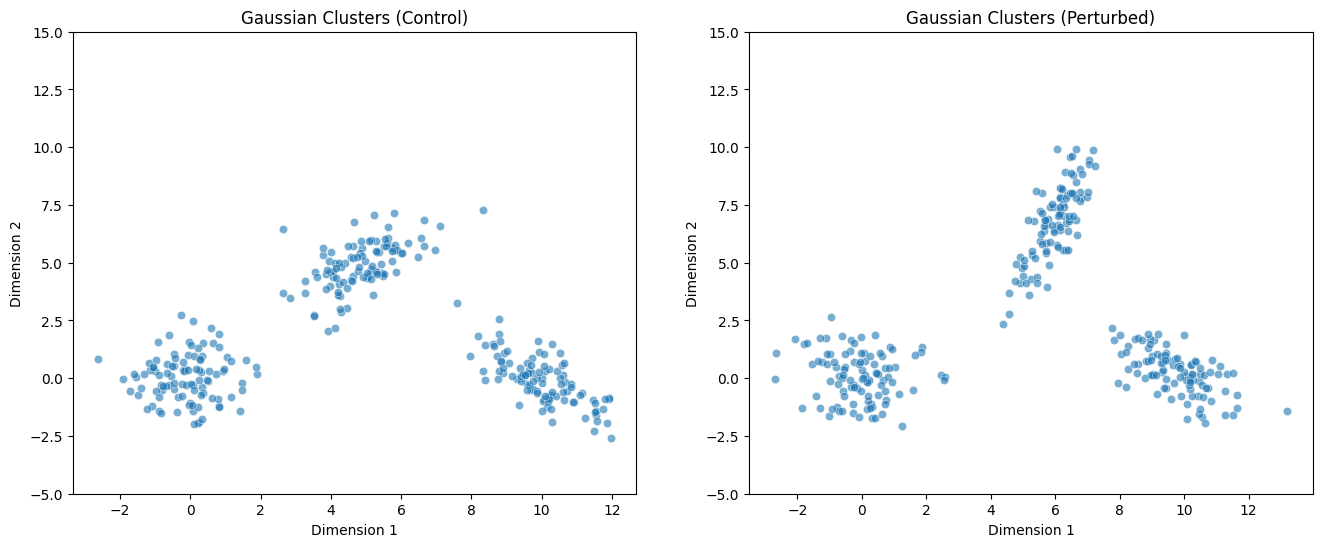

In [739]:
# 2D Gaussian Clusters
def generate_gaussian_cluster_dataset(n_samples_per_cluster=100, random_seed=42):
    # Create the control dataset
    np.random.seed(random_seed)
    means = [(0, 0), (5, 5), (10, 0)]
    covariances = [np.array([[1, 0], [0, 1]]),  # Identity matrix for cluster 1
                    np.array([[1, 0.5], [0.5, 1]]),  # Slightly correlated features for cluster 2
                    np.array([[1, -0.7], [-0.7, 1]])]  # Negatively correlated features for cluster 3
    
    X = []
    y = []  
    for i, (mean, cov) in enumerate(zip(means, covariances)):
        cluster_samples = np.random.multivariate_normal(mean, cov, n_samples_per_cluster)
        X.append(cluster_samples)
        y.append(np.full(n_samples_per_cluster, i)) 
    X = np.vstack(X)
    y = np.hstack(y)

    # Create the perturbed dataset by modifying the mean and covariance of one of the clusters
    means = [(0, 0), (6, 7), (10, 0)]
    covariances = [np.array([[1, 0], [0, 1]]),  # Identity matrix for cluster 1
                np.array([[0.5, 2], [1,3]]),  #
                np.array([[1, -0.7], [-0.7, 1]])]  # Negatively correlated features for cluster 3
    X_perturbed = []
    for i, (mean, cov) in enumerate(zip(means, covariances)):
        cluster_samples = np.random.multivariate_normal(mean, cov, n_samples_per_cluster)
        X_perturbed.append(cluster_samples)
        
    X_perturbed = np.vstack(X_perturbed)
    
    return X, X_perturbed, y

# create both datasets
X_2d_gaussian_example, X_perturbed_2d_gaussian_example, cluster_labels = generate_gaussian_cluster_dataset(n_samples_per_cluster=100, random_seed=42)

# plot both datasets
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,6))
ax1.set_ylim(-5, 15)
ax1.set_title("Gaussian Clusters (Control)")
ax1.set_xlabel("Dimension 1")
ax1.set_ylabel("Dimension 2")
sns.scatterplot(x=X_2d_gaussian_example[:,0], y=X_2d_gaussian_example[:,1], ax=ax1, alpha=0.6)

ax2.set_ylim(-5, 15)
ax2.set_title("Gaussian Clusters (Perturbed)")
ax2.set_xlabel("Dimension 1")
ax2.set_ylabel("Dimension 2")
sns.scatterplot(x=X_perturbed_2d_gaussian_example[:,0], y=X_perturbed_2d_gaussian_example[:,1], ax=ax2, alpha=0.6)
plt.show()

Building graph on 600 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.04 seconds.
  Calculating affinities...
  Calculated affinities in 0.03 seconds.
Calculated graph and diffusion operator in 0.11 seconds.


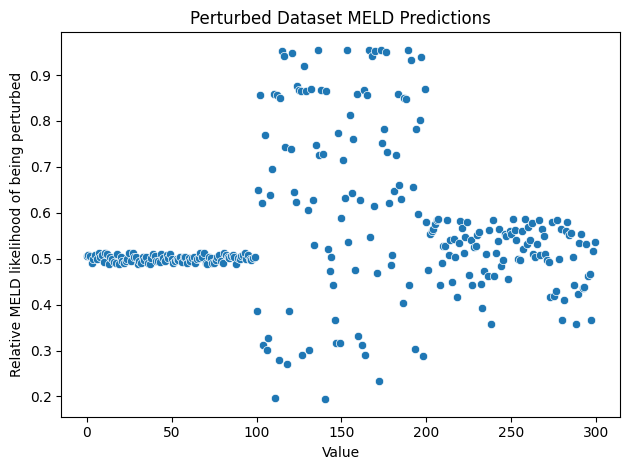

In [740]:
# Run MELD on the 2D Gaussian Clusters example
gaussian_2d_example_dataset_combined = np.concatenate((X_2d_gaussian_example, X_perturbed_2d_gaussian_example))
gaussian_2d_example_dataset_labels = np.concatenate((['control'] * X_2d_gaussian_example.shape[0], 
                                ['perturbed'] *  X_perturbed_2d_gaussian_example.shape[0]))

# Estimate density of each sample over the graph
meld_op = meld.MELD(beta=60, knn=8)
gaussian_2d_example_sample_densities = meld_op.fit_transform(gaussian_2d_example_dataset_combined, gaussian_2d_example_dataset_labels)
# Normalize densities to calculate sample likelihoods
gaussian_2d_example_sample_likelihoods = meld.utils.normalize_densities(gaussian_2d_example_sample_densities)

plt.title("Perturbed Dataset MELD Predictions")
plt.xlabel("Value")
plt.ylabel("Relative MELD likelihood of being perturbed")
sns.scatterplot(gaussian_2d_example_sample_likelihoods['perturbed'][-X_perturbed_2d_gaussian_example.shape[0]:].to_numpy())
plt.tight_layout()


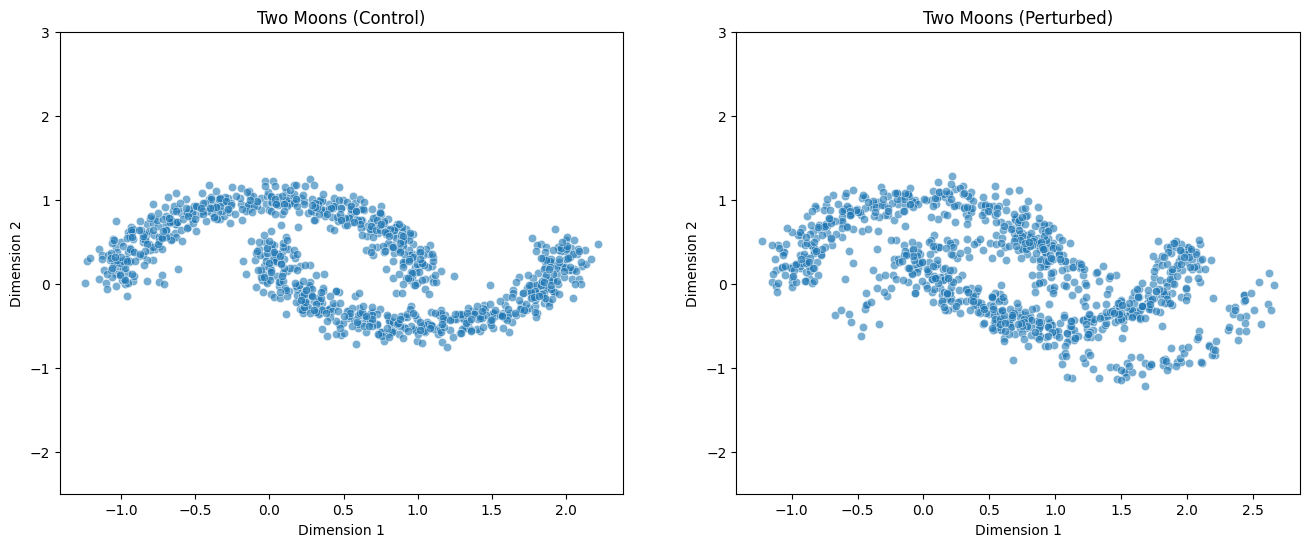

In [846]:
# 2D Two Moons Dataset
# Set random seed for reproducibility
def make_two_moons_datasets(n_samples):
    fraction_to_perturb = 0.25
    
    # Generate a two-moon dataset
    noise_level = 0.1
    X, _ = make_moons(n_samples=n_samples, noise=0.1)

    num_to_perturb = int(n_samples * fraction_to_perturb)
    
    X_perturbed,_ = make_moons(n_samples=n_samples, noise=0.11)

    X_perturbed[-num_to_perturb:] += [0.5,-0.5] # simplest perturbation i could think of
    return X, X_perturbed, np.arange(n_samples-num_to_perturb,n_samples)

two_moons_X, two_moons_X_perturbed, two_moons_perturbed_indices = make_two_moons_datasets(n_samples=1000)

# plot both datasets
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,6))
ax1.set_ylim(-2.5,3)
ax1.set_title("Two Moons (Control)")
ax1.set_xlabel("Dimension 1")
ax1.set_ylabel("Dimension 2")
sns.scatterplot(x=two_moons_X[:,0], y=two_moons_X[:,1], ax=ax1, alpha=0.6)

ax2.set_ylim(-2.5,3)
ax2.set_title("Two Moons (Perturbed)")
ax2.set_xlabel("Dimension 1")
ax2.set_ylabel("Dimension 2")
sns.scatterplot(x=two_moons_X_perturbed[:,0], y=two_moons_X_perturbed[:,1], ax=ax2, alpha=0.6)
plt.show()

Building graph on 2000 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 0.03 seconds.
  Calculating affinities...
  Calculated affinities in 0.01 seconds.
Calculated graph and diffusion operator in 0.06 seconds.


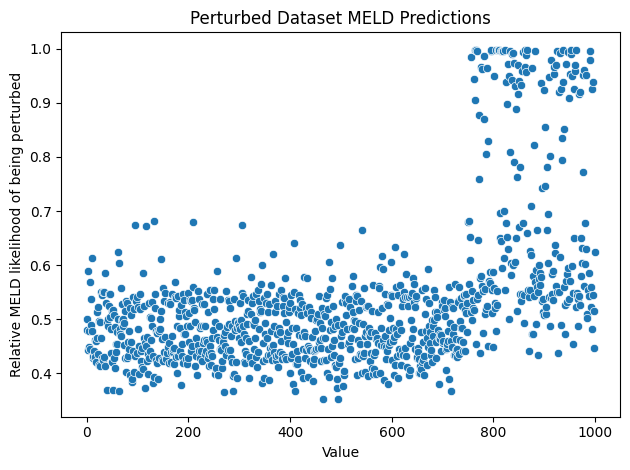

In [847]:
# run MELD on the two moons example
two_moons_combined = np.concatenate((two_moons_X, two_moons_X_perturbed))
two_moons_labels = np.concatenate((['control'] * two_moons_X.shape[0], 
                                ['perturbed'] *  two_moons_X_perturbed.shape[0]))

# Estimate density of each sample over the graph
meld_op = meld.MELD(beta=30, knn=8)
two_moons_sample_densities = meld_op.fit_transform(two_moons_combined , two_moons_labels)
# Normalize densities to calculate sample likelihoods
two_moons_sample_likelihoods = meld.utils.normalize_densities(two_moons_sample_densities)

plt.title("Perturbed Dataset MELD Predictions")
plt.xlabel("Value")
plt.ylabel("Relative MELD likelihood of being perturbed")
sns.scatterplot(two_moons_sample_likelihoods['perturbed'][two_moons_X_perturbed.shape[0]:].to_numpy())
plt.tight_layout()

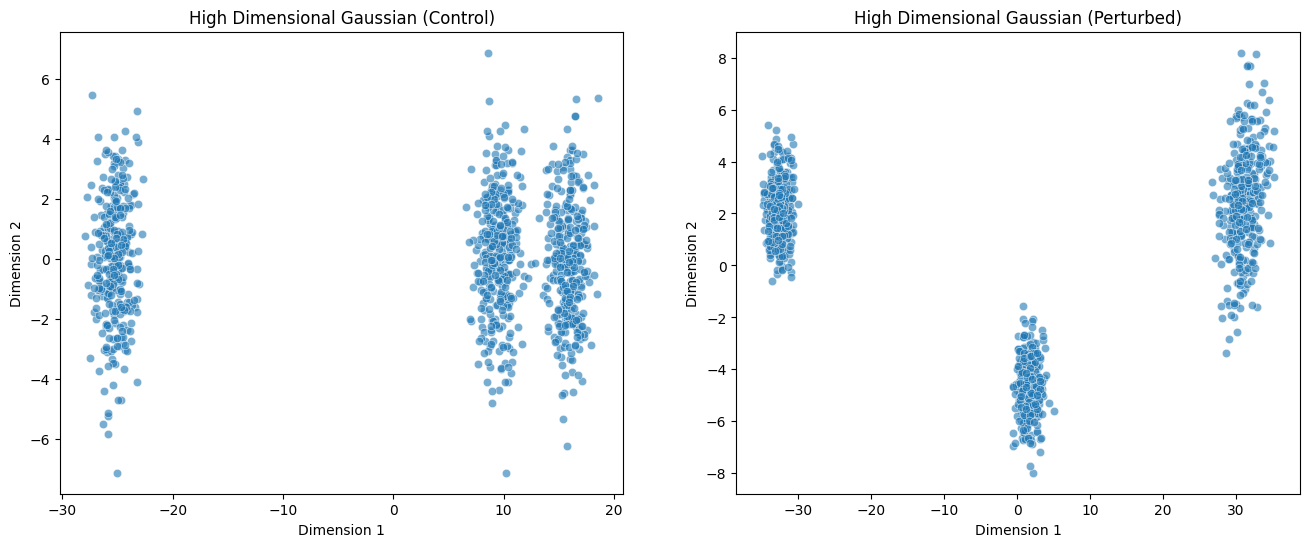

In [920]:
# high dimensional gaussian example
# perturbation is random feature scaling
def generate_high_dimensional_gaussian_feature_scaled_dataset(n_samples, n_features, perturbation_fraction=0.15):
    n_samples_per_cluster= int(n_samples / 3)
    means = [np.zeros(n_features), 
                 np.ones(n_features) * 1.1, 
                 np.ones(n_features) * 1.3]
    
    covariances = [np.eye(n_features) for _ in range(3)]  # Identity matrices for all clusters
    
    X = []
    y = []
    
    for i, (mean, cov) in enumerate(zip(means, covariances)):
        cluster_samples = np.random.multivariate_normal(mean, cov, n_samples_per_cluster)
        X.append(cluster_samples)
        y.append(np.full(n_samples_per_cluster, i))
    
    X_a = np.vstack(X)

    X = []
    for i, (mean, cov) in enumerate(zip(means, covariances)):
        cluster_samples = np.random.multivariate_normal(mean, cov, n_samples_per_cluster)
        if i == 2: # scale the features of the third cluster
            scaling_factors = np.random.uniform(1,2, size=n_features)
            cluster_samples *= scaling_factors   
        X.append(cluster_samples)

    X_b = np.vstack(X)

    return X_a, X_b, np.arange(X_b.shape[0] - n_samples_per_cluster, X_b.shape[0])

high_dimension_feature_scale_X, high_dimension_feature_scale_X_perturbed, \
    perturbation_indices = generate_high_dimensional_gaussian_feature_scaled_dataset(1000, 1000, perturbation_fraction=0.15)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(high_dimension_feature_scale_X)
X_p_pca = pca.fit_transform(high_dimension_feature_scale_X_perturbed)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,6))
ax1.set_title("High Dimensional Gaussian (Control)")
ax1.set_xlabel("Dimension 1")
ax1.set_ylabel("Dimension 2")
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], ax=ax1, alpha=0.6)

ax2.set_title("High Dimensional Gaussian (Perturbed)")
ax2.set_xlabel("Dimension 1")
ax2.set_ylabel("Dimension 2")
sns.scatterplot(x=X_p_pca[:, 0], y=X_p_pca[:, 1], ax=ax2, alpha=0.6)
plt.show()

Building graph on 1998 samples and 1000 features.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 0.67 seconds.
  Calculating KNN search...
  Calculated KNN search in 0.23 seconds.
  Calculating affinities...
  Calculated affinities in 0.18 seconds.
Calculated graph and diffusion operator in 1.15 seconds.


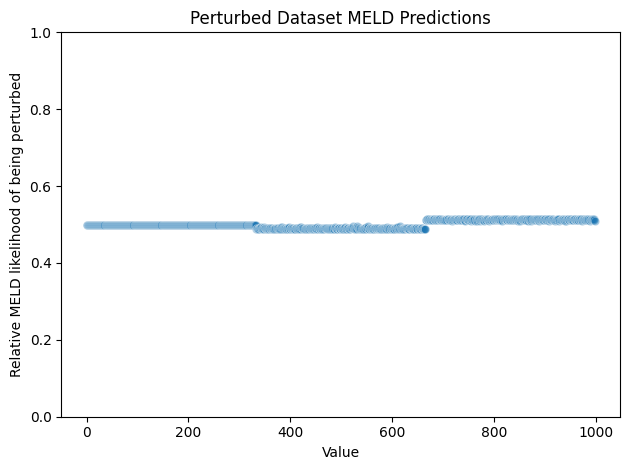

In [921]:
# Run MELD on high dimensional feature scaling example
high_dimension_feature_scale_combined = np.concatenate((high_dimension_feature_scale_X, high_dimension_feature_scale_X_perturbed))
high_dimension_feature_scale_labels = np.concatenate((['control'] * high_dimension_feature_scale_X.shape[0], 
                                ['perturbed'] *  high_dimension_feature_scale_X_perturbed.shape[0]))

# Estimate density of each sample over the graph
meld_op = meld.MELD(beta=60, knn=6)
high_dimension_feature_scale_sample_densities = meld_op.fit_transform(high_dimension_feature_scale_combined, high_dimension_feature_scale_labels)
# Normalize densities to calculate sample likelihoods
high_dimension_feature_scale_sample_likelihoods = meld.utils.normalize_densities(high_dimension_feature_scale_sample_densities)

plt.title("Perturbed Dataset MELD Predictions")
plt.ylim(0,1)
plt.xlabel("Value")
plt.ylabel("Relative MELD likelihood of being perturbed")
sns.scatterplot(high_dimension_feature_scale_sample_likelihoods['perturbed'][-high_dimension_feature_scale_X_perturbed.shape[0]:].to_numpy(), alpha=0.4)
plt.tight_layout()

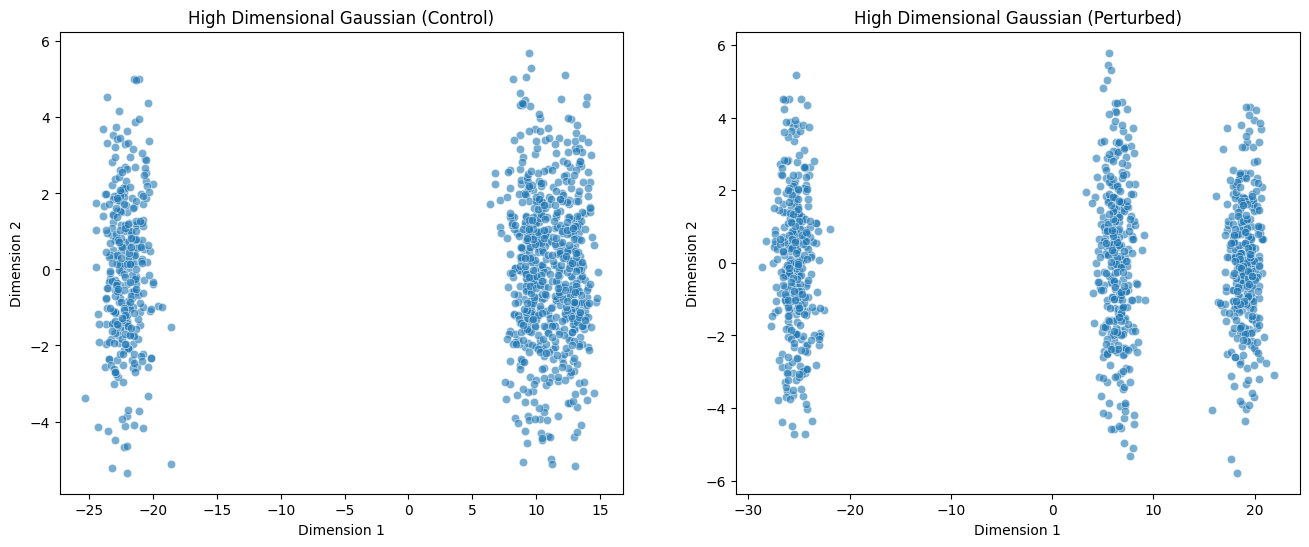

In [916]:
# High Dimensional Gaussians, Translating one of the clusters
def generate_high_dimensional_gaussian_translated_dataset(n_samples, n_features, perturbation_fraction=0.15):
    n_samples_per_cluster= int(n_samples / 3)
    means = [np.zeros(n_features), 
                np.ones(n_features),
                np.ones(n_features) * 1.1]
    
    covariances = [np.eye(n_features) for _ in range(3)]  # Identity matrices for all clusters

    # generate control dataset
    X = []
    for i, (mean, cov) in enumerate(zip(means, covariances)):
        cluster_samples = np.random.multivariate_normal(mean, cov, n_samples_per_cluster)
        X.append(cluster_samples)
    X_a = np.vstack(X)

    # generate the perturbed dataset
    X = []
    for i, (mean, cov) in enumerate(zip(means, covariances)):
        cluster_samples = np.random.multivariate_normal(mean, cov, n_samples_per_cluster)
        if i == 2:
            cluster_samples += 0.3
        X.append(cluster_samples)

    X_b = np.vstack(X)

    return X_a, X_b, np.arange(X_b.shape[0] - n_samples_per_cluster, X_b.shape[0])

high_dimension_translate_X, high_dimension_translate_X_perturbed, \
    perturbation_indices = generate_high_dimensional_gaussian_translated_dataset(1000, 1000, perturbation_fraction=0.15)
pca = PCA(n_components=2)

X_pca = pca.fit_transform(high_dimension_translate_X)
X_p_pca = pca.fit_transform(high_dimension_translate_X_perturbed)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,6))
ax1.set_title("High Dimensional Gaussian (Control)")
ax1.set_xlabel("Dimension 1")
ax1.set_ylabel("Dimension 2")
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], ax=ax1, alpha=0.6)

ax2.set_title("High Dimensional Gaussian (Perturbed)")
ax2.set_xlabel("Dimension 1")
ax2.set_ylabel("Dimension 2")
sns.scatterplot(x=X_p_pca[:, 0], y=X_p_pca[:, 1], ax=ax2, alpha=0.6)
plt.show()

Building graph on 1998 samples and 1000 features.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 0.92 seconds.
  Calculating KNN search...
  Calculated KNN search in 0.29 seconds.
  Calculating affinities...
  Calculated affinities in 0.18 seconds.
Calculated graph and diffusion operator in 1.45 seconds.


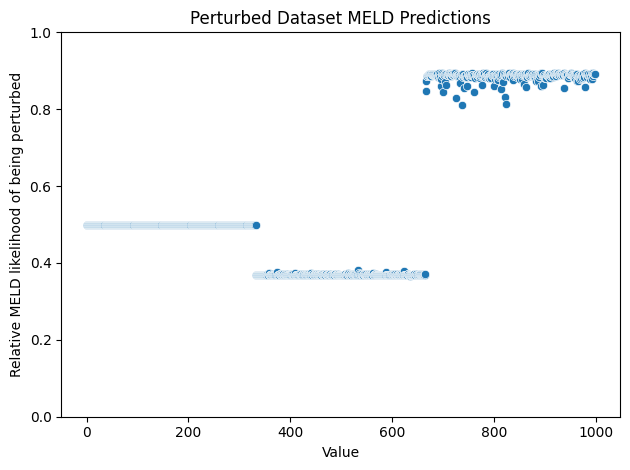

In [917]:
# Run MELD on high dimensional cluster translation example
high_dimension_translate_combined = np.concatenate((high_dimension_translate_X, high_dimension_translate_X_perturbed))
high_dimension_translate_labels = np.concatenate((['control'] * high_dimension_translate_X.shape[0], 
                                ['perturbed'] *  high_dimension_translate_X_perturbed.shape[0]))

# Estimate density of each sample over the graph
meld_op = meld.MELD(beta=60, knn=6)
high_dimension_translate_sample_densities = meld_op.fit_transform(high_dimension_translate_combined, high_dimension_translate_labels)
# Normalize densities to calculate sample likelihoods
high_dimension_translate_sample_likelihoods = meld.utils.normalize_densities(high_dimension_translate_sample_densities)

plt.title("Perturbed Dataset MELD Predictions")
plt.ylim(0,1)
plt.xlabel("Value")
plt.ylabel("Relative MELD likelihood of being perturbed")
sns.scatterplot(high_dimension_translate_sample_likelihoods['perturbed'][-high_dimension_translate_X_perturbed.shape[0]:].to_numpy())
plt.tight_layout()